<hr/>
# **Predicting House Prices**
<span id="0"></span>
[**Burhan Y. Kiyakoglu**](https://www.kaggle.com/burhanykiyakoglu)
<hr/>
<font color=green>
1. [Overview](#1)
1. [Importing Modules, Reading the Dataset and Defining an Evaluation Table](#2)
1. [Defining a Function to Calculate the Adjusted $R^{2}$ ](#3)
1. [Creating a Simple Linear Regression](#4)
    * [Let's Show the Result](#5)
1. [Visualizing and Examining Data](#6)
    * [Checking Out the Correlation Among Explanatory Variables](#7)
1. [Data Preprocessing](#8)
    * [Binning](#9)
1. [Multiple Regression](#10)    
    * [Multiple Regression - 1](#11)
    * [Multiple Regression - 2](#12)
    * [Multiple Regression - 3](#13)
    * [Multiple Regression - 4](#14)
1. [Regularization](#15)
    * [Ridge Regression](#16)
    * [Lasso Regression](#17)
1. [Polynomial Regression](#18)  
1. [k-NN Regression](#19)
1. [Evaluation Table](#20)    
1. [Conclusion](#21)

# <span id="1"></span> Overview
<hr/>
Welcome to my Kernel! In this kernel, I use various regression methods and try to predict the house prices by using them. As you can guess, there are various methods to suceed this and each method has pros and cons. I think **regression is one of the most important methods because it gives us more insight about the data**. When we ask **why**, it is easier to interpret the relation between the response and explanatory variables. 

I start with a very simple model and continue with more complex ones after visualizing some features and a data mining process. I try to find the best regression for this dataset. 

On the other hand, if you are looking for more theory and do not want to use built in functions, I recommend you to check my other kernel [k-NN, Logistic Regression, k-Fold CV from Scratch](https://www.kaggle.com/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch).

If you have a question or feedback, do not hesitate to write and if you like this kernel, please <b><font color="red">do not forget to </font><font color="green">UPVOTE </font></b> 🙂 

<br/>
<img src="https://i.imgur.com/kCNAFTN.jpg?1" title="source: imgur.com" />

# <span id="2"></span> Importing Modules, Reading the Dataset and Defining an Evaluation Table
#### [Return Contents](#0)
<hr/>

In order to make some analysis, we need to set our environment up. To do this, I firstly imported some modules and read data. The below output is the head of the data but if you want to see more details, you might try removing ***#*** signs in front of the ***df.describe()*** and ***df.info()***.  

Further, I defined an empty dataframe. This dataframe includes **Root Mean Squared Error (RMSE), R-squared, Adjusted R-squared** and **mean of the R-squared values obtained by the k-Fold Cross Validation**, which are the important metrics to compare different models. Having a **R-squared value closer to one** and **smaller RMSE** means a better fit. In the following sections, I will fill this dataframe with my results.

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

df = pd.read_csv('kc_house_data.csv')
#df.describe()
#df.info()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# <span id="3"></span> Defining a Function to Calculate the Adjusted $R^{2}$
#### [Return Contents](#0)
<hr/>

The R-squared increases when the number of features increase. Because of this, sometimes a more robust evaluator is preferred to compare the performance between different models. This evaluater is called adjusted R-squared and it only increases, if the addition of the variable reduces the MSE. The definition of the adjusted $R^{2}$ is:

$\bar{R^{2}}=R^{2}-\frac{k-1}{n-k}(1-R^{2})$

where $n$ is the number of observations and $k$ is the number of parameters. 

In [8]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

# <span id="4"></span> Creating a Simple Linear Regression
#### [Return Contents](#0)
<hr/>

When we model a linear relationship between a response and **just one** explanatory variable, this is called **simple linear regression**. I want to predict house prices and then, our response variable is price. However, for a simple model we also need to select a feature. When I look at the columns of the dataset, living area (sqft) seemed the most important feature. When we examine the  <a href=#7>correlation matrix</a>, we may observe that price has the highest correlation coefficient with living area (sqft) and this also supports my opinion. Thus, I decided to use **living area (sqft)** as feature but if you want to examine the relationship between price and another feature, you may prefer that feature.

In [9]:
#%%capture
train_data,test_data = train_test_split(df,train_size = 0.8,random_state=3)

lr = linear_model.LinearRegression()
X_train = np.array(train_data['sqft_living'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['sqft_living'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,df[['sqft_living']],df['price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))

r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression','-',rmsesm,rtrsm,'-',rtesm,'-',cv]
evaluation

Average Price for Test Data: 539744.130
Intercept: -47235.81130290101
Coefficient: [282.2468152]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,254289.149,0.492,-,0.496,-,0.491


[](http://)I also printed the intercept and coefficient for the simple linear regression. By using these values and the below definition, we can estimate the house prices manually. The equation we use for our estimations is called hypothesis function and defined as

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x$$

## <span id="5"></span> Let's Show the Result

Since we have just **two** dimensions at the simple regression, it is **easy to draw** it. The below chart determines the result of the simple regression. It does not look like a perfect fit but when we work with real world datasets, having a perfect fit is not easy.

In [10]:
sns.set(style="white", font_scale=1)

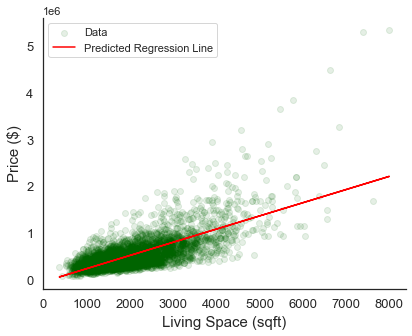

In [11]:
plt.figure(figsize=(6.5,5))
plt.scatter(X_test,y_test,color='darkgreen',label="Data", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Living Space (sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# <span id="6"></span> Visualizing and Examining Data
#### [Return Contents](#0)
<hr/>

This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. Drawing charts and examining the data before applying a model is a very good practice because we may detect some possible outliers or decide to do normalization. This is not a must but get know the data is always good. Then, I started with the histograms of dataframe.

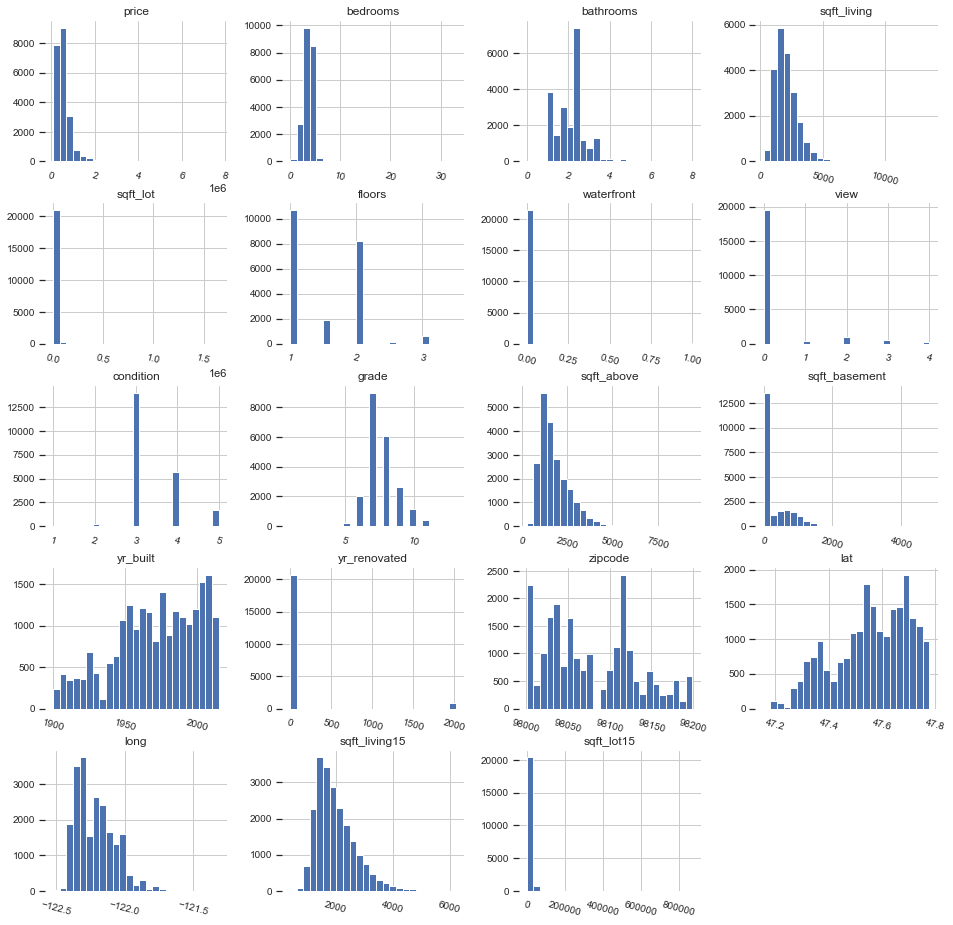

In [12]:
df1=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

To determine bedrooms, floors or bathrooms/bedrooms vs price, I preferred **boxplot** because we have numerical data but they are not continuous as 1,2,... bedrooms, 2.5, 3,... floors (probably 0.5 stands for the penthouse). 

From the below charts, it can be seen that there are very few houses which have some features or price appears far from others like 33 bedrooms or price around 7000000. However, determining their possible negative effect will be time consuming and in the real data sets there will always be some outliers like some luxury house prices in this dataset. That's why I am not planning to remove outliers.

In [13]:
sns.set(style="whitegrid", font_scale=1)

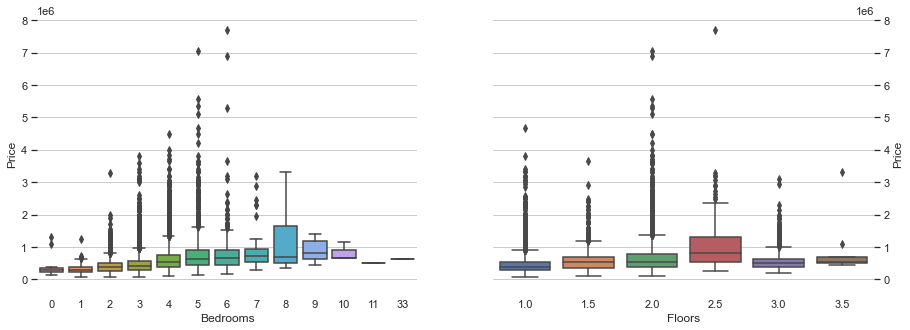

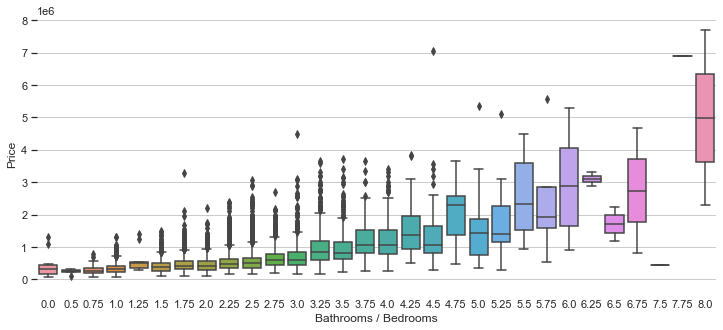

In [14]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['floors'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price');

I drew the price vs some features and it seems that there is not a perfect linear relationship between the price and these features. On the other hand, what about the relationship among each other? To show this, I preferred 3D plots. Also, I used light green as the  point color. Dark green parts mean high density, many light green points overlap and become darker. 

The below charts show that when the sqrt_living increases, sqrt_lot and bedrooms or bathrooms/bedrooms increases. However, the floors, bedrooms and bathrooms/bedrooms or sqrt_living does not have a similar relationship.  

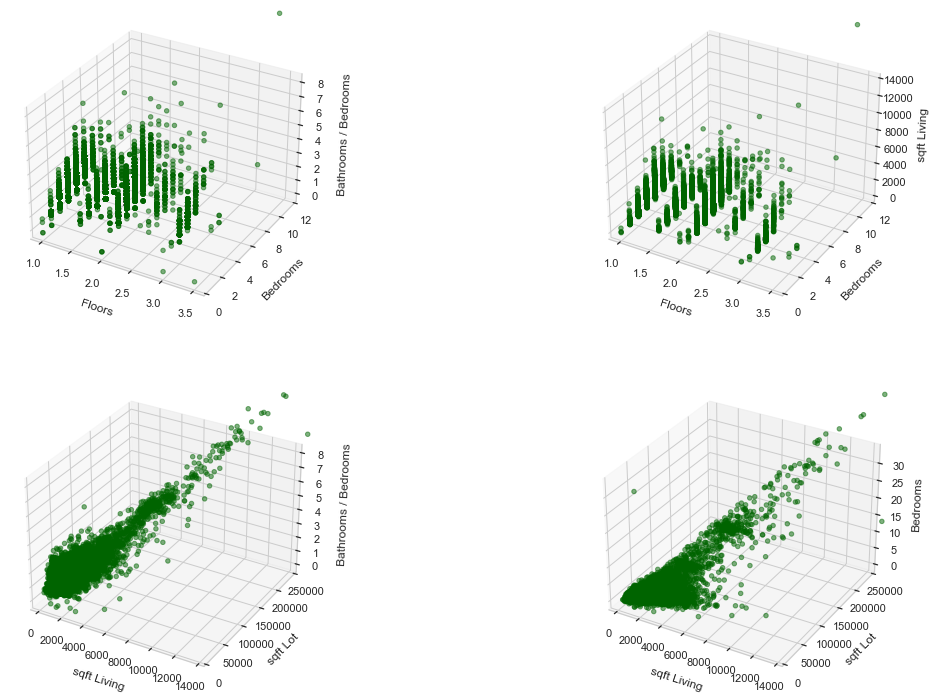

In [15]:
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,1, projection="3d")
ax.scatter(df['floors'],df['bedrooms'],df['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nBathrooms / Bedrooms')
ax.set(ylim=[0,12])

ax=fig.add_subplot(2,2,2, projection="3d")
ax.scatter(df['floors'],df['bedrooms'],df['sqft_living'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nsqft Living')
ax.set(ylim=[0,12])

ax=fig.add_subplot(2,2,3, projection="3d")
ax.scatter(df['sqft_living'],df['sqft_lot'],df['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='\nBathrooms / Bedrooms')
ax.set(ylim=[0,250000])

ax=fig.add_subplot(2,2,4, projection="3d")
ax.scatter(df['sqft_living'],df['sqft_lot'],df['bedrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='Bedrooms')
ax.set(ylim=[0,250000]);

Let's visualize more features. When we look at the below boxplots, grade and waterfront effect price visibly. On the other hand, view seem to effect less but it also has an effect on price. 

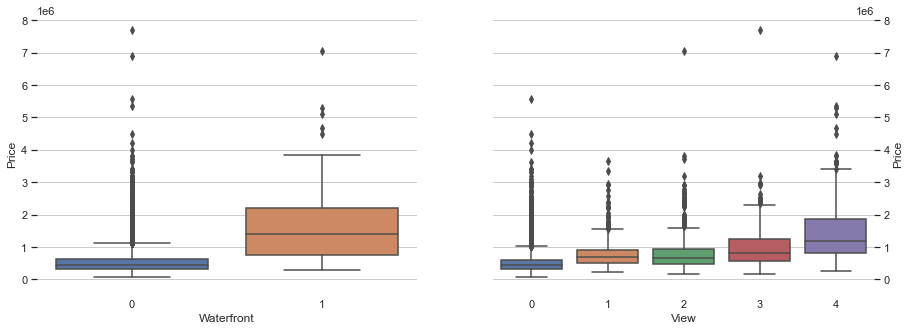

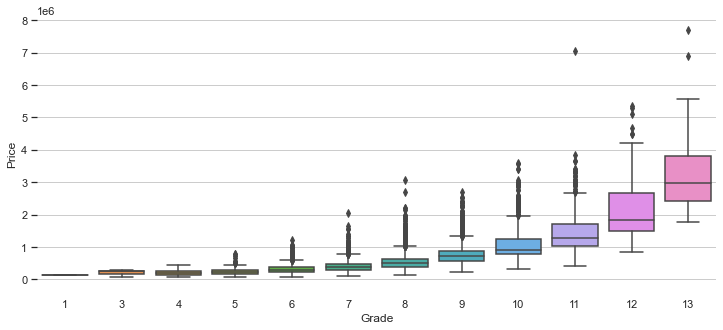

In [16]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['waterfront'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['view'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.boxplot(x=df['grade'],y=df['price'], ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price');

Further, I drew the 3D plot to determine the relation between the view, grade and year built. The below chart shows that the newer houses have better grades but we can not say much about the change in the view.  

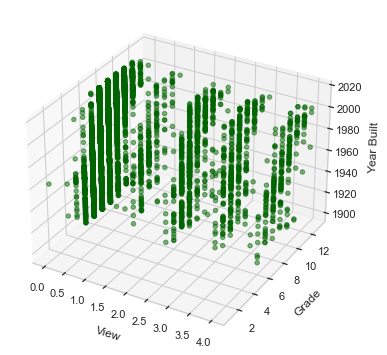

In [17]:
fig=plt.figure(figsize=(9.5,6.25))
ax=fig.add_subplot(1,1,1, projection="3d")
ax.scatter(train_data['view'],train_data['grade'],train_data['yr_built'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nView',ylabel='\nGrade',zlabel='\nYear Built');

## <span id="7"></span> Checking Out the Correlation Among Explanatory Variables

Having too many features in a model is not always a good thing because it might cause overfitting and worser results when we want to predict values for a new dataset. Thus, **if a feature does not improve your model a lot, not adding it may be a better choice**.

Another important thing is correlation. **If there is very high correlation between two features, keeping both of them is not a good idea most of the time not to cause overfitting**. For instance, if there is overfitting, we may remove sqt_above or sqt_living because they are highly correlated. This relation can be estimated when we look at the definitions in the dataset but to be sure correlation matrix should be checked. However, this does not mean that you must remove one of the highly correlated features. For example: bathrooms and sqrt_living. They are highly correlated but I do not think that the relation among them is the same as the relation between sqt_living and sqt_above.

<ipython-input-18-1198850be72c>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df[features].corr(), dtype=np.bool)


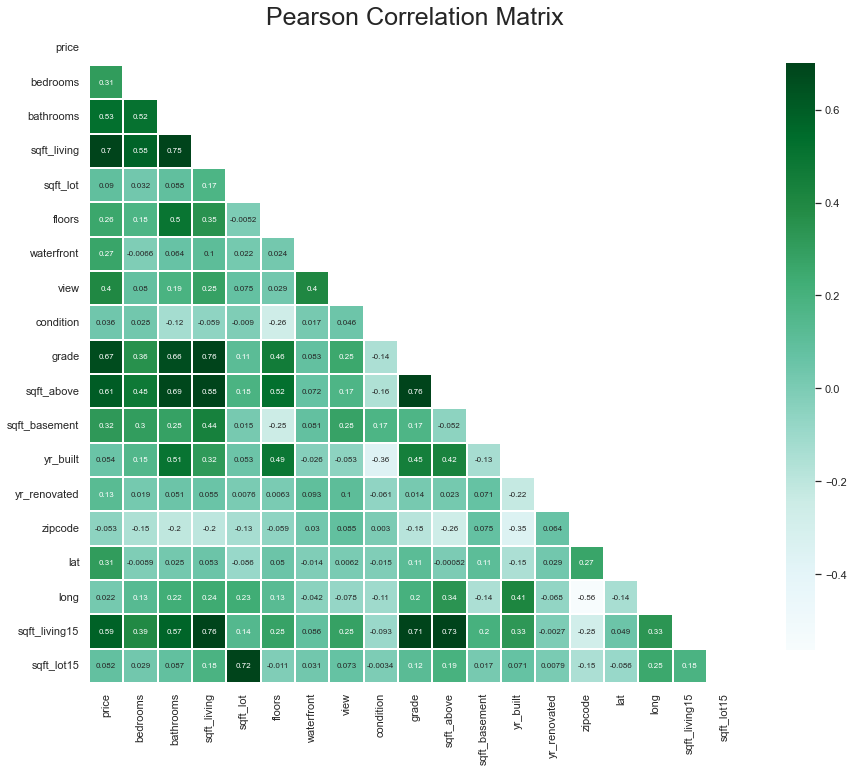

In [18]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# <span id="8"></span> Data Preprocessing
#### [Return Contents](#0)
<hr/>

A preprocessing on data might improve the model accuracy and make the model more reliable. It does not always have to improve our results but when we are conscious of the features and use a proper input, we might reach some outcomes easier. I tried various data mining techniques like transformation or normalization but in the end, decided to just use binning and created a new dataframe called ***df_dm***.

In [19]:
df_dm=df.copy()
df_dm.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## <span id="9"></span> Binning

Data binning is a preprocessing technique used to reduce the effects of minor observation errors. I think it is worthwhile applying to some columns of this dataset. I applied binning to *yr_built* and *yr_renovated*. I added the ages and renovation ages of the houses when they were sold. Also, I partitioned these columns to intervals and you can observe this in the below **histograms**. 

<ipython-input-20-b02f773a1d0e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dm['age_rnv'][df_dm['age_rnv'].isnull()]=0
c:\Users\PC10\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\PC10\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


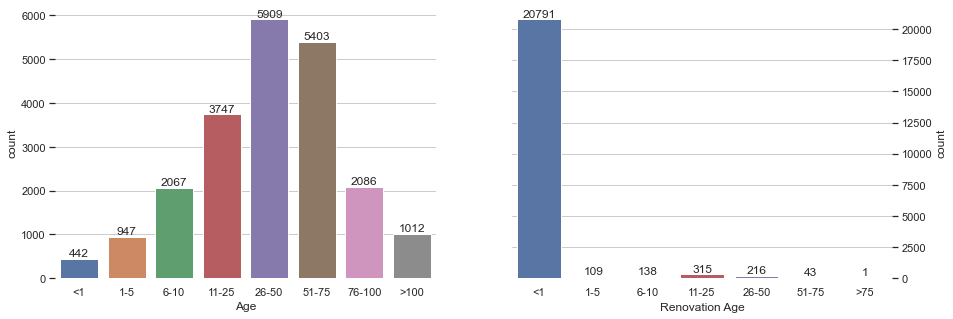

In [20]:
# just take the year from the date column
df_dm['sales_yr']=df_dm['date'].astype(str).str[:4]

# add the age of the buildings when the houses were sold as a new column
df_dm['age']=df_dm['sales_yr'].astype(int)-df_dm['yr_built']
# add the age of the renovation when the houses were sold as a new column
df_dm['age_rnv']=0
df_dm['age_rnv']=df_dm['sales_yr'][df_dm['yr_renovated']!=0].astype(int)-df_dm['yr_renovated'][df_dm['yr_renovated']!=0]
df_dm['age_rnv'][df_dm['age_rnv'].isnull()]=0

# partition the age into bins
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df_dm['age_binned'] = pd.cut(df_dm['age'], bins=bins, labels=labels)
# partition the age_rnv into bins
bins = [-2,0,5,10,25,50,75,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','>75']
df_dm['age_rnv_binned'] = pd.cut(df_dm['age_rnv'], bins=bins, labels=labels)

# histograms for the binned columns
f, axes = plt.subplots(1, 2,figsize=(15,5))
p1=sns.countplot(df_dm['age_binned'],ax=axes[0])
for p in p1.patches:
    height = p.get_height()
    p1.text(p.get_x()+p.get_width()/2,height + 50,height,ha="center")   
p2=sns.countplot(df_dm['age_rnv_binned'],ax=axes[1])
sns.despine(left=True, bottom=True)
for p in p2.patches:
    height = p.get_height()
    p2.text(p.get_x()+p.get_width()/2,height + 200,height,ha="center")
    
axes[0].set(xlabel='Age')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Renovation Age');

# transform the factor values to be able to use in the model
df_dm = pd.get_dummies(df_dm, columns=['age_binned','age_rnv_binned'])

In [21]:
df_dm

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,age_binned_51-75,age_binned_76-100,age_binned_>100,age_rnv_binned_<1,age_rnv_binned_1-5,age_rnv_binned_6-10,age_rnv_binned_11-25,age_rnv_binned_26-50,age_rnv_binned_51-75,age_rnv_binned_>75
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,0,0,0,1,0,0,0,0,0,0
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,0,0,0,1,0,0,0,0,0,0
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,0,0,0,1,0,0,0,0,0,0
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,0,0,0,1,0,0,0,0,0,0


# <span id="10"></span> Multiple Regression
#### [Return Contents](#0)
<hr/>

I used a <a href=#4>simple linear regression</a> and found a poor fit. In order to improve this model I am planing to add more features. When we have **more than one** feature in a linear regression, it is defined as **multiple regression**. Then, it is time to create some complex models.

## <span id="11"></span> Multiple Regression - 1

I determined ***features*** at first sight by looking at the previous sections and used in my first multiple linear regression. As in the simple regression, I printed the coefficients which the model uses for the predictions. However, this time we must use the below definition for our predictions, if we want to make calculations manually.

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+...+\theta_{n}x_{n}$$

In [22]:
train_data_dm,test_data_dm = train_test_split(df_dm,train_size = 0.8,random_state=3)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','zipcode']
complex_model_1 = linear_model.LinearRegression()
complex_model_1.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_1.intercept_))
print('Coefficients: {}'.format(complex_model_1.coef_))

pred = complex_model_1.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_1.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_1.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_1.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_1.score(test_data_dm[features],test_data['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_1,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-1','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -57221293.13485922
Coefficients: [-5.68950279e+04  1.13310062e+04  3.18389287e+02 -2.90807628e-01
 -5.79609821e+03  5.84022824e+02]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512
0,Simple Linear Regression,-,254289.149,0.492,-,0.496,-,0.491


## <span id="12"></span> Multiple Regression - 2

In addition to the previous subsection, I added more features to the ***features*** list. Also, I printed the coefficients of the model as in the previous subsection. When we look at the evaluation metrics, they improved significantly.

In [23]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
             'grade','age_binned_<1', 'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 
             'age_binned_26-50', 'age_binned_51-75','age_binned_76-100', 'age_binned_>100',
             'zipcode']
complex_model_2 = linear_model.LinearRegression()
complex_model_2.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_2.intercept_))
print('Coefficients: {}'.format(complex_model_2.coef_))

pred = complex_model_2.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_2.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_2.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_2.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_2.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_2,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-2','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 14932064.4567095
Coefficients: [-3.74523328e+04  4.83495326e+04  1.71684976e+02 -2.31081061e-01
  1.03590806e+04  5.56285921e+05  4.78399848e+04  1.24143045e+05
 -8.88123227e+04 -1.05756567e+05 -1.04723750e+05 -1.35898725e+05
 -5.37336956e+04  8.41048129e+04  1.84153081e+05  2.20667166e+05
 -1.60046391e+02]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512
0,Simple Linear Regression,-,254289.149,0.492,-,0.496,-,0.491


## <span id="13"></span> Multiple Regression - 3

In order to observe differences easily, I created a model with all features without any preprossing. Evaluation metrics improved remarkable again.  

In [24]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_3 = linear_model.LinearRegression()
complex_model_3.fit(train_data[features],train_data['price'])

print('Intercept: {}'.format(complex_model_3.intercept_))
print('Coefficients: {}'.format(complex_model_3.coef_))

pred = complex_model_3.predict(test_data[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_3.score(train_data[features],train_data['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_3.score(train_data[features],train_data['price']),train_data.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_3.score(test_data[features],test_data['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_3.score(test_data[features],test_data['price']),test_data.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_3,df[features],df['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-3','all features, no preprocessing',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 7580919.940330271
Coefficients: [-3.51323305e+04  4.25821114e+04  1.10705020e+02  1.13581822e-01
  6.82992716e+03  5.61794985e+05  5.28174040e+04  2.48918356e+04
  9.57708783e+04  7.01998424e+01  4.05051775e+01 -2.70948034e+03
  2.26715091e+01 -5.80427853e+02  5.98629230e+05 -2.08875497e+05
  2.32857416e+01 -3.75353459e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
3,Multiple Regression-3,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512
0,Simple Linear Regression,-,254289.149,0.492,-,0.496,-,0.491


## <span id="14"></span> Multiple Regression - 4

This time I used the data obtained after preprocessing step.

In [25]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_4 = linear_model.LinearRegression()
complex_model_4.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_4.intercept_))
print('Coefficients: {}'.format(complex_model_4.coef_))

pred = complex_model_4.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_4.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_4.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_4.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_4.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_4,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-4','all features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 8748434.764224969
Coefficients: [-3.33491904e+04  3.76549641e+04  1.10716182e+02  1.22826592e-01
 -1.26725956e+04  5.69817402e+05  5.41386091e+04  3.17275550e+04
  9.52300581e+04  7.05366854e+01  4.01795268e+01 -4.46861874e+04
 -5.43838963e+04 -7.11287025e+04 -8.93583274e+04 -5.92594439e+04
  3.70943651e+04  1.22837694e+05  1.58884499e+05 -1.97812401e+04
  9.43034022e+04  8.74164248e+04  4.14131931e+04 -1.50309593e+04
 -1.06990366e+05 -8.13304552e+04 -6.50061210e+02  6.03335811e+05
 -2.10031732e+05  2.42386074e+01 -3.08651553e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512
0,Simple Linear Regression,-,254289.149,0.492,-,0.496,-,0.491


# <span id="15"></span> Regularization
#### [Return Contents](#0)
<hr/>

**Regularization** is designed to address the problem of overfitting and undefitting. **Overfitting** means high variance and is usually caused by a complicated function that creates a lot of unnecessary curves and angles unrelated to the data. This function fits training data well but might cause poor results for the test set. On the other hand, **underfitting** means low variance and a very simple model. This might also cause poor results too. **Possible remedies** are adjusting features manually or using some model selection algoritms which brings an extra workload. Conversely, when we apply regularization, all the features are kept and the model adjusts $\theta_{j}$. This especially works when we have a lot of slightly useful features. There are two widely used regularization types (Ridge and Lasso Regressions) and in this section, I used them.

**When to use ridge vs lasso regression:**
*  Many small/medium sized effects: use *ridge*.
*  Only a few variables with medium/large effect: use *lasso*.


## <span id="16"></span> Ridge Regression

Ridge regression is called **L2 regularization** and by adding a penalty, we obtain the below equation

$$RSS_{RIDGE} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}\theta^{2}_{j}$$

By changing the $\alpha$ value, we can control the amount of the regularization. When we increase $\alpha$, regularization increases and the opposite is valid too. As a result of this, I selected different $\alpha$ values and used a linear regression without regularization in order to observe the differences easily.

In [26]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_R = linear_model.Ridge(alpha=1)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_R.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=100)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_R.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=1000)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_R.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Ridge Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Ridge Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
5,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
6,Ridge Regression,"alpha=100, all features",195372.495,0.694,0.693,0.703,0.701,0.691
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
7,Ridge Regression,"alpha=1000, all features",209625.468,0.651,0.65,0.658,0.655,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512
0,Simple Linear Regression,-,254289.149,0.492,-,0.496,-,0.491


## <span id="17"></span> Lasso Regression

Lasso regression is called **L1 regularization** and it is defined as

$$RSS_{LASSO} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}|\theta_{j}|$$

The main difference between ridge and lasso is the penalty but $\alpha$ works the same way.   

In [27]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_L = linear_model.Lasso(alpha=1)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_L.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=100)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_L.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=1000)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_L.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Lasso Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Lasso Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.206e+14, tolerance: 2.358e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e+14, tolerance: 2.258e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e+14, tolerance: 

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
5,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
8,Lasso Regression,"alpha=1, all features",191880.918,0.701,0.7,0.713,0.711,0.698
9,Lasso Regression,"alpha=100, all features",192060.144,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
10,Lasso Regression,"alpha=1000, all features",193587.943,0.697,0.697,0.708,0.706,0.695
6,Ridge Regression,"alpha=100, all features",195372.495,0.694,0.693,0.703,0.701,0.691
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
7,Ridge Regression,"alpha=1000, all features",209625.468,0.651,0.65,0.658,0.655,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512


# <span id="18"></span> Polynomial Regression
#### [Return Contents](#0)
<hr/>

For the linear models, the main idea is to fit a straight line to our data. However, if the data has a quadratic distribution, this time choosing a quadratic function and applying a polynomial transformation may give us better results. This time the hypothesis function is defined as

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x+\theta_{2}x^{2}+...+\theta_{n}x^{n}$$

Since there are many variations for the polynomial regression, I prefered to show results by a new table and it can be seen from the below table that polynomial transformation improved the model fit a lot. On the other hand, while using polynomial transformation and deciding to degree, we should be very careful because it **migh cause overfitting**. Also, in the below table overfitting exists for some models. The 5-fold cross validation metrics are negative or low for these models although they have very high R-squared values for the training set.

In [28]:
evaluation_poly = pd.DataFrame({'Model': [],
                                'Details':[],
                                'Root Mean Squared Error (RMSE)':[],
                                'R-squared (training)':[],
                                'Adjusted R-squared (training)':[],
                                'R-squared (test)':[],
                                'Adjusted R-squared (test)':[],
                                '5-Fold Cross Validation':[]})

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
             'grade','yr_built','zipcode']
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred1 = poly.predict(X_testpoly)
rmsepoly1 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred1)),'.3f'))
rtrpoly1 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly1 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv1 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred2 = poly.predict(X_testpoly)
rmsepoly2 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred2)),'.3f'))
rtrpoly2 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly2 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv2 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred3 = poly.predict(X_testpoly)
rmsepoly3 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred3)),'.3f'))
rtrpoly3 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly3 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv3 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred4 = poly.predict(X_testpoly)
rmsepoly4 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred4)),'.3f'))
rtrpoly4 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly4 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv4 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))


features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred5 = poly.predict(X_testpoly)
rmsepoly5 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred5)),'.3f'))
rtrpoly5 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly5 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv5 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Ridge(alpha=1).fit(X_trainpoly, train_data['price'])

pred6 = poly.predict(X_testpoly)
rmsepoly6 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred6)),'.3f'))
rtrpoly6 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly6 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv6 = float(format(cross_val_score(linear_model.Ridge(alpha=1),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Ridge(alpha=50000).fit(X_trainpoly, train_data['price'])

pred7 = poly.predict(X_testpoly)
rmsepoly7 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred7)),'.3f'))
rtrpoly7 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly7 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv7 = float(format(cross_val_score(linear_model.Ridge(alpha=50000),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Lasso(alpha=1).fit(X_trainpoly, train_data['price'])

pred8 = poly.predict(X_testpoly)
rmsepoly8 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred8)),'.3f'))
rtrpoly8 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly8 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv8 = float(format(cross_val_score(linear_model.Lasso(alpha=1),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Lasso(alpha=50000).fit(X_trainpoly, train_data['price'])

pred9 = poly.predict(X_testpoly)
rmsepoly9 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred9)),'.3f'))
rtrpoly9 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly9 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv9 = float(format(cross_val_score(linear_model.Lasso(alpha=50000),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation_poly.shape[0]
evaluation_poly.loc[r] = ['Polynomial Regression','degree=2, selected features, no preprocessing',rmsepoly1,rtrpoly1,'-',rtepoly1,'-',cv1]
evaluation_poly.loc[r+1] = ['Polynomial Regression','degree=3, selected features, no preprocessing',rmsepoly2,rtrpoly2,'-',rtepoly2,'-',cv2]
evaluation_poly.loc[r+2] = ['Polynomial Regression','degree=2, all features, no preprocessing',rmsepoly3,rtrpoly3,'-',rtepoly3,'-',cv3]
evaluation_poly.loc[r+3] = ['Polynomial Regression','degree=3, all features, no preprocessing',rmsepoly4,rtrpoly4,'-',rtepoly4,'-',cv4]
evaluation_poly.loc[r+4] = ['Polynomial Regression','degree=2, all features',rmsepoly5,rtrpoly5,'-',rtepoly5,'-',cv5]
evaluation_poly.loc[r+5] = ['Polynomial Ridge Regression','alpha=1, degree=2, all features',rmsepoly6,rtrpoly6,'-',rtepoly6,'-',cv6]
evaluation_poly.loc[r+6] = ['Polynomial Ridge Regression','alpha=50000, degree=2, all features',rmsepoly7,rtrpoly7,'-',rtepoly7,'-',cv7]
evaluation_poly.loc[r+7] = ['Polynomial Lasso Regression','alpha=1, degree=2, all features',rmsepoly8,rtrpoly8,'-',rtepoly8,'-',cv8]
evaluation_poly.loc[r+8] = ['Polynomial Lasso Regression','alpha=50000, degree=2, all features',rmsepoly9,rtrpoly9,'-',rtepoly9,'-',cv9]
evaluation_poly_temp = evaluation_poly[['Model','Details','Root Mean Squared Error (RMSE)','R-squared (training)','R-squared (test)','5-Fold Cross Validation']]
evaluation_poly_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)

c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.24489e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.66815e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e+14, tolerance: 2.358e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\PC10\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),R-squared (test),5-Fold Cross Validation
2,Polynomial Regression,"degree=2, all features, no preprocessing",151169.202,0.830,0.822,0.813
6,Polynomial Ridge Regression,"alpha=50000, degree=2, all features",159872.571,0.810,0.801,0.791
8,Polynomial Lasso Regression,"alpha=50000, degree=2, all features",166020.484,0.797,0.785,0.779
7,Polynomial Lasso Regression,"alpha=1, degree=2, all features",166195.984,0.807,0.785,0.778
0,Polynomial Regression,"degree=2, selected features, no preprocessing",191862.766,0.728,0.713,0.714
1,Polynomial Regression,"degree=3, selected features, no preprocessing",188772.614,0.749,0.722,0.517
3,Polynomial Regression,"degree=3, all features, no preprocessing",189347.227,0.874,0.721,0.204
5,Polynomial Ridge Regression,"alpha=1, degree=2, all features",150177.030,0.838,0.824,-3198.424
4,Polynomial Regression,"degree=2, all features",151471.072,0.840,0.821,-16909.596


# <span id="19"></span> k-NN Regression 
#### [Return Contents](#0)
<hr/>

I included k-NN regression in this kernel but actually, I did not expect to obtain a good result by using it. Also, k-NN does not give much insight. It is a very simple method and the idea behind the algorithm is similar to the k-NN classification. Briefly, it uses the weighted average, median or another statistic you want of k-nearest instances.

The evaluation metrics for the training, test sets and different *k* values were given in the below table. It can be seen that, k-NN was not very successful as expected. 

In [29]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
knnreg = KNeighborsRegressor(n_neighbors=15)
knnreg.fit(train_data_dm[features],train_data_dm['price'])
pred = knnreg.predict(test_data_dm[features])

rmseknn1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn1 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn1 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn1 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn1 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

knnreg = KNeighborsRegressor(n_neighbors=25)
knnreg.fit(train_data_dm[features],train_data_dm['price'])
pred = knnreg.predict(test_data_dm[features])

rmseknn2 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn2 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn2 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn2 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn2 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

knnreg = KNeighborsRegressor(n_neighbors=27)
knnreg.fit(train_data_dm[features],train_data_dm['price'])
pred = knnreg.predict(test_data_dm[features])

rmseknn3 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn3 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn3 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn3 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn3 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['KNN Regression','k=15, all features',rmseknn1,rtrknn1,artrknn1,rteknn1,arteknn1,cv1]
evaluation.loc[r+1] = ['KNN Regression','k=25, all features',rmseknn2,rtrknn2,artrknn2,rteknn2,arteknn2,cv2]
evaluation.loc[r+2] = ['KNN Regression','k=27, all features',rmseknn3,rtrknn3,artrknn3,rteknn3,arteknn3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
5,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
8,Lasso Regression,"alpha=1, all features",191880.918,0.701,0.7,0.713,0.711,0.698
9,Lasso Regression,"alpha=100, all features",192060.144,0.701,0.7,0.713,0.711,0.698
3,Multiple Regression-3,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
10,Lasso Regression,"alpha=1000, all features",193587.943,0.697,0.697,0.708,0.706,0.695
6,Ridge Regression,"alpha=100, all features",195372.495,0.694,0.693,0.703,0.701,0.691
2,Multiple Regression-2,selected features,209712.753,0.652,0.652,0.657,0.656,0.648
7,Ridge Regression,"alpha=1000, all features",209625.468,0.651,0.65,0.658,0.655,0.648
1,Multiple Regression-1,selected features,248514.011,0.514,0.514,0.519,0.518,0.512


# <span id="20"></span> Evaluation Table
#### [Return Contents](#0)
<hr/>

In [30]:
evaluation_temp=evaluation.append(evaluation_poly)
evaluation_temp1=evaluation_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)
evaluation_temp2=evaluation_temp1.reset_index()
evaluation_f=evaluation_temp2.iloc[:,1:]
evaluation_f

<ipython-input-30-14e954508748>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_temp=evaluation.append(evaluation_poly)


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Polynomial Regression,"degree=2, all features, no preprocessing",151169.202,0.830,-,0.822,-,0.813
1,Polynomial Ridge Regression,"alpha=50000, degree=2, all features",159872.571,0.810,-,0.801,-,0.791
2,Polynomial Lasso Regression,"alpha=50000, degree=2, all features",166020.484,0.797,-,0.785,-,0.779
3,Polynomial Lasso Regression,"alpha=1, degree=2, all features",166195.984,0.807,-,0.785,-,0.778
4,Polynomial Regression,"degree=2, selected features, no preprocessing",191862.766,0.728,-,0.713,-,0.714
5,Multiple Regression-4,all features,191879.550,0.701,0.7,0.713,0.711,0.698
6,Ridge Regression,"alpha=1, all features",191903.548,0.701,0.7,0.713,0.711,0.698
7,Lasso Regression,"alpha=1, all features",191880.918,0.701,0.7,0.713,0.711,0.698
8,Lasso Regression,"alpha=100, all features",192060.144,0.701,0.7,0.713,0.711,0.698
9,Multiple Regression-3,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695


# <span id="21"></span> Conclusion
#### [Return Contents](#0)
<hr/>

When we look at the evaluation table, **2nd degree polynomial (all features, no preprocessing)** is the best. However, I have doubts about its reliability. I would prefer the **polynomial ridge regression (alpha=50000, degree=2, all features)** but other models might be useful depending to the situation too. 

In this kernel, I used scikit-learn which provides me all built in functions I need but if you want to examine the **theory** behind the **logistic regression**, which is used for classification and similar to the linear regression, and some other methods, you might also want to check my other kernel [k-NN, Logistic Regression, k-Fold CV from Scratch](https://www.kaggle.com/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch).

<b><font color="green">Thank you for reading my kernel </font></b> **and If you liked it, please** <b><font color="red">do not forget to <b></font><font color="green">UPVOTE </font></b> 🙂 